In [7]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
from nucleixspot import nucleixspot_adata, morphology_differences

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.2.0 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8
squidpy==1.2.2


# Load the data

Download the cropped adata and the full resolution image for separate segmentation using QuPath

In [3]:
adata_st = sq.datasets.visium_hne_adata_crop()
# img = sq.datasets.visium_hne_image_crop()

In [4]:
adata_st

AnnData object with n_obs × n_vars = 684 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

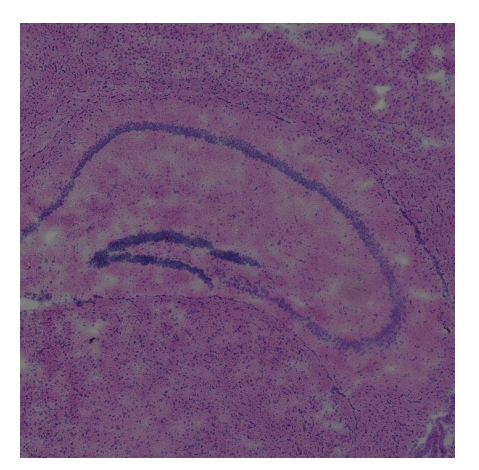

In [13]:
sc.pl.spatial(
    adata_st, frameon=False, show=False
)
plt.tight_layout()

# Calculate nuclei per spot

Using the detection results from QuPath, we calculate the aggregated nuclei features per ST spot. 

In [8]:
tissue_positions = pd.DataFrame(adata_st.obsm['spatial'], columns=['img_x', 'img_y'], index=adata_st.obs.index)
spot_diameter_fullres = 89.44395653112628 # From spatial/scalefactors_json.json
measurements = pd.read_csv('/home/eduard/nucleixspot/measurements.csv')

In [9]:
adata_st = nucleixspot_adata(adata_st, 
                             tissue_positions=tissue_positions, 
                             spot_diameter=spot_diameter_fullres, 
                             measurements=measurements, 
                             position_coords=['img_x','img_y'], 
                             measurements_coords=['Centroid X µm', 'Centroid Y µm'], 
                             qs=[0.05, 0.5, 0.95], 
                             selected_features=['Nucleus: Area'], 
                             pixels=False, 
                             resolution=1)

In [10]:
adata_st

AnnData object with n_obs × n_vars = 684 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster', 'n_detections', 'Nucleus: Area_percentage', 'Nucleus: Area_5', 'Nucleus: Area_50', 'Nucleus: Area_95'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

# Visualize the features per spot

In this case, we can see, for instance, how the Pyramidal layers have a higher nuclei area percentage compared to the Hippocampus

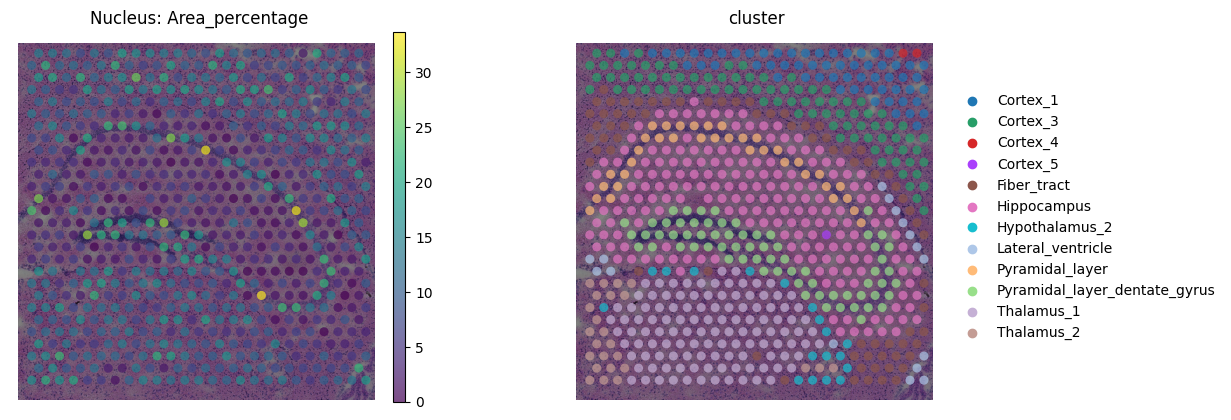

In [11]:
sc.pl.spatial(
    adata_st, color=["Nucleus: Area_percentage", "cluster"], alpha=0.7, frameon=False,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Pyramidal_layer v.s. Pyramidal_layer_dentate_gyrus: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.400e-01 U_stat=1.404e+03
Hippocampus v.s. Pyramidal_layer: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.336e-10 U_stat=1.025e+03


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Cortex_1'),
  Text(1, 0, 'Cortex_3'),
  Text(2, 0, 'Cortex_4'),
  Text(3, 0, 'Cortex_5'),
  Text(4, 0, 'Fiber_tract'),
  Text(5, 0, 'Hippocampus'),
  Text(6, 0, 'Hypothalamus_2'),
  Text(7, 0, 'Lateral_ventricle'),
  Text(8, 0, 'Pyramidal_layer'),
  Text(9, 0, 'Pyramidal_layer_dentate_gyrus'),
  Text(10, 0, 'Thalamus_1'),
  Text(11, 0, 'Thalamus_2')])

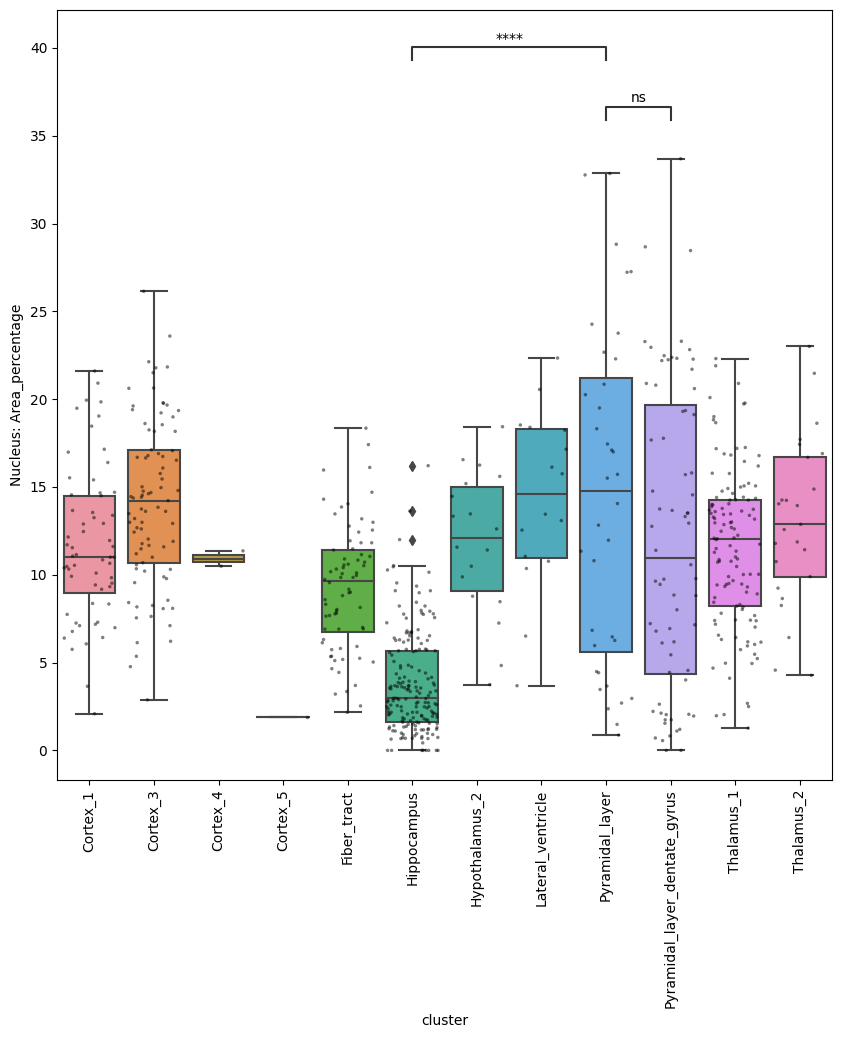

In [12]:
plt.figure(figsize=(10,10))
ax = morphology_differences(x='cluster',
                       y='Nucleus: Area_percentage',
                       data=adata_st.obs,
                       stats=True,
                       box_pairs=[('Pyramidal_layer', 'Hippocampus'),
                                  ('Pyramidal_layer', 'Pyramidal_layer_dentate_gyrus')],
                       stripplot=True
                       )
plt.xticks(rotation=90)